In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection, metrics
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras
from time import time
import glob
from keras.callbacks import TensorBoard


import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['.ipynb_checkpoints', 'mnist_submit-Copy3.ipynb', 'model2.csv', 'test.csv', 'train.csv', 'mnist_submit-Copy2.ipynb', 'Untitled1.ipynb', 'model0.csv', 'model1.csv', 'model1.ipynb', 'mnist_submit.ipynb', 'EDA.ipynb', 'Untitled.ipynb']


Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [3]:
def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=None)
    test = pd.DataFrame.from_csv(test_path, index_col=None)
              
    return train, test

In [4]:
train, test = load_data()

/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
train_X = train.drop("label", axis=1)
train_y = train["label"]

In [6]:
train_X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [7]:
train_X = train_X.div(255, axis=0).fillna(0)
test = test.div(255, axis=0).fillna(0)

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_y, test_size=0.2, shuffle=None)

In [9]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):

    steps_per_period = steps / periods  

    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )

    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=cols,
        n_classes=10,
        optimizer=my_optimizer,
        hidden_units=[64, 128, 64],
        model_dir=m_dir
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        classifier.evaluate(input_fn=validation_input_fn)
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=ptraining_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)

        validation_predictions = list(classifier.predict(input_fn=validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(y_train, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(y_test, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])

    accuracy = metrics.accuracy_score(y_test, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(y_test, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

In [10]:
cols = [tf.feature_column.numeric_column(i) for i in train_X.columns.values]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_tf_random_seed': None, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_device_fn': None, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_ps_replicas': 0, '_task_type': 'worker', '_model_dir': '/tmp/model1', '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_protocol': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fead6ff99b0>, '_eval_distribute': None, '_master': '', '_evaluation_master': '', '_servic

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 02 : 6.96
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-60
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 60 into /tmp/model1/model.ckpt.
INFO:tensorflow:loss = 115.32904, step = 61
INFO:tensorflow:Saving checkpoints for 80 into /tmp/model1/model.ckpt.
INFO:tensorflow:Loss for final step: 89.1226.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-17T02:58:01Z
INFO:t

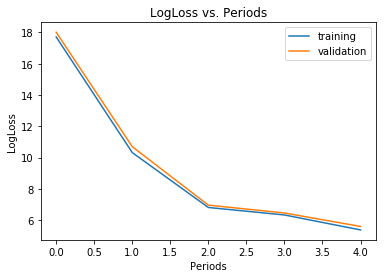

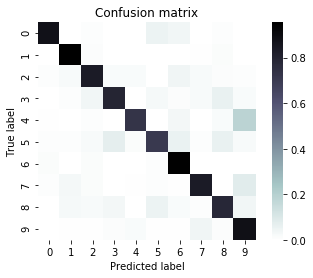

In [11]:
model1 = train_classification_model(
    learning_rate=0.005,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model1',
    periods=5)

In [12]:
scores1 = model1.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores1):
    res.append([i + 1, p['class_ids'][0]])   

result = pd.DataFrame(res, columns=['ImageId', 'Label'])
result.to_csv('model1.csv', index=None)

NameError: name 'scores0' is not defined